# Inventory management via Python / JAX / linear operators

In [37]:
import quantecon as qe
import numpy as np
from collections import namedtuple
from numba import njit, prange, int32
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys

## Model and Primitives

In [38]:
def f(y, a, d):
    " Inventory update rule. "
    return np.maximum(y - d, 0) + a 

In [39]:
Params = namedtuple(   # Stores model parameters
         "Params", ("K", "c", "κ", "p"))

In [40]:
def build_R(params, y_vals, d_vals, ϕ_vals):
    K, c, κ, p = params
    n_y = K + 1
    n_d = len(d_vals)
    # Create R[y, a, yp, d] and then sum out last dimension
    y  = np.reshape(y_vals, (n_y, 1, 1, 1))
    a  = np.reshape(y_vals, (1, n_y, 1, 1))
    yp = np.reshape(y_vals, (1, 1, n_y, 1))
    d  = np.reshape(d_vals, (1, 1, 1, n_d))
    ϕ  = np.reshape(ϕ_vals, (1, 1, 1, n_d))
    feasible = a <= K - y
    temp = (f(y, a, d_vals) == yp) * feasible
    R = np.sum(temp * ϕ_vals, axis=3)
    return R

In [41]:
def build_r(params, y_vals, d_vals, ϕ_vals):
    K, c, κ, p = params
    n_y = K + 1
    n_d = len(d_vals)
    y = np.reshape(y_vals, (n_y, 1))
    d = np.reshape(d_vals, (1, n_d))
    ϕ = np.reshape(ϕ_vals, (1, n_d))
    revenue = np.minimum(y, d) * ϕ 
    exp_revenue = np.sum(revenue, axis=1)
    exp_revenue = np.reshape(exp_revenue, (n_y, 1))
    a = np.reshape(y_vals, (1, n_y))
    cost = c * a + κ * (a > 0)
    exp_profit = exp_revenue - cost
    feasible = a <= K - y
    r = np.where(feasible, exp_profit, -np.inf)
    return r

In [42]:
Arrays = namedtuple(  # Stores arrays for model
         "Arrays", ("r", "R", "y_vals", "z_vals", "Q"))

In [43]:
Model = namedtuple(   # Stores all model data
        "Model", ("params", "sizes", "arrays"))

In [44]:
def create_sdd_inventory_model(ρ=0.98,        # Z persistence
                               ν=0.002,       # Z volatility
                               n_z=12,        # size of Z grid
                               b=0.97,        # Z mean
                               K=100,         # max inventory        
                               d_max=100,     # max value of d
                               c=0.2,         # unit cost
                               κ=0.8,         # fixed cost
                               p=0.6):        # demand parameter

    """
    Stores inventory management model primitives and default values.

    The discount factor takes the form β_t = Z_t, where (Z_t) is a 
    Tauchen discretization of the Gaussian AR(1) process 

        Z_t = ρ Z_{t-1} + b + ν W_t.

    """


    n_y = K + 1               # size of state space
    y_vals = np.arange(n_y)   # inventory levels 0,...,K

    # Construct r and R arrays
    def ϕ(d):
        return (1 - p)**d * p                      
    d_vals = np.arange(d_max)
    ϕ_vals = ϕ(d_vals)

    # Build the exogenous discount process 
    mc = qe.tauchen(n_z, ρ, ν)
    z_vals, Q = mc.state_values + b, mc.P

    # Test spectral radius condition
    ρL = np.max(np.abs(np.linalg.eigvals(z_vals * Q)))     
    if ρL >= 1:
        raise NotImplementedError("Error: ρ(L) ≥ 1.")
    else:
        print(f"Building model with ρ(L) = {ρL}")

    # Build namedtuples and return them
    params = Params(K=K, c=c, κ=κ, p=p)
    r = build_r(params, y_vals, d_vals, ϕ_vals)
    R = build_R(params, y_vals, d_vals, ϕ_vals)

    arrays = Arrays(r=r, R=R, y_vals=y_vals, z_vals=z_vals, Q=Q)
    sizes = n_y, n_z
    return Model(params=params, sizes=sizes, arrays=arrays)

## DP algorithms

In [45]:
def value_function_iteration(v_init, 
                             T,
                             get_greedy,
                             tolerance=1e-6,        # Error tolerance
                             max_iter=10_000,       # Max iteration bound
                             print_step=25,         # Print at multiples
                             verbose=False,
                             usejax=False):
    """
        Compute v_star via VFI and then compute greedy.
    """
    array_lib = jnp if usejax else np

    v = v_init
    error = tolerance + 1
    k = 1
    while error > tolerance and k <= max_iter:
        v_new = T(v)
        error = array_lib.max(array_lib.abs(v_new - v))
        if verbose and (k % print_step) == 0:
            print(f"Completed iteration {k} with error {error}.")
        v = v_new
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    elif verbose:
        print(f"VFI terminated successfully in {k} iterations.")
    v_star = v
    σ_star = get_greedy(v_star)
    return v_star, σ_star

In [46]:
def optimistic_policy_iteration(v_init, 
                                T_σ,
                                get_greedy,
                                m=20,
                                tolerance=1e-6, 
                                max_iter=1_000,
                                print_step=10,
                                verbose=False,
                                usejax=False):
    "Optimistic policy iteration routine."
    
    array_lib = jnp if usejax else np
    v = v_init
    error = tolerance + 1
    k = 1
    while error > tolerance and k < max_iter:
        last_v = v
        σ = get_greedy(v)
        for i in range(m):
            v = T_σ(v, σ)
        error = array_lib.max(array_lib.abs(v - last_v))
        if verbose and k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        k += 1
    if error > tolerance:
        print(f"Warning: Iteration hit upper bound {max_iter}.")
    else: 
        print(f"OPI terminated successfully in {k} iterations (m = {m}).")
    return v, get_greedy(v)

In [47]:
def howard_policy_iteration(v_init, 
                            get_value,
                            get_greedy,
                            verbose=False,
                            usejax=False):
    "Howard policy iteration routine."
    array_lib = jnp if usejax else np

    σ = get_greedy(v_init)
    i, error = 0, 1.0
    while error > 0:
        v_σ = get_value(σ)
        σ_new = get_greedy(v_σ)
        error = array_lib.max(array_lib.abs(σ_new - σ))
        σ = σ_new
        i = i + 1
        if verbose:
            print(f"Concluded loop {i} with error {error}.")
    print(f"HPI converged in {i} iteration(s).")
    return v_σ, σ

## Code for simulations and plots

In [48]:
def sim_inventories(model, σ_star, ts_length, Y_init=0, seed=500):
    """
        Simulate inventory dynamics and interest rates given an 
        optimal policy σ_star.
    """
    # Set up
    np.random.seed(seed)
    K, c, κ, p = model.params
    r, R, y_vals, z_vals, Q = model.arrays

    # Generate Markov chain for discount factor
    z_mc = qe.MarkovChain(Q, z_vals)
    i_z = z_mc.simulate_indices(ts_length, init=1, random_state=seed)

    # Generate corresponding inventory series
    Y = np.zeros(ts_length, dtype=int)
    Y[0] = Y_init
    for t in range(ts_length - 1):
        D = np.random.geometric(p) - 1
        a = σ_star[Y[t], i_z[t]] 
        Y[t+1] = f(Y[t],  a,  D)

    # Return both series
    return Y, z_vals[i_z]

In [49]:
def plot_ts(model,
            σ_star,
            ts_length=400,
            fontsize=12, 
            figname="ts.pdf",
            savefig=False):
    """
        Solve model, plot a time series of inventory and interest rates.

    """

    # Obtain inventory and discount factor series
    Y, Z = sim_inventories(model, σ_star, ts_length)
    r = (1 / Z) - 1 # calculate interest rate from discount factors

    # Plot
    fig, axes = plt.subplots(2, 1, figsize=(9, 5.5))
    ax = axes[0]
    ax.plot(Y, label="inventory", alpha=0.7)
    ax.set_xlabel("time", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_ylim(0, np.max(Y)+3)
    ax = axes[1]
    ax.plot(r, label="$r_t$", alpha=0.7)
    ax.set_xlabel("$t$", fontsize=fontsize)
    ax.legend(fontsize=fontsize, frameon=False)
    plt.tight_layout()
    plt.show()
    if savefig:
        fig.savefig(figname)

In [50]:
def plot_timing(hpi_time, 
                vfi_time,
                opi_times,
                m_vals, 
                figname="timing.pdf",
                fontsize=12,
                savefig=False):
    """
    Plot relative timing of different algorithms.

    """
    fig, ax = plt.subplots(figsize=(9, 5.2))

    y_values = (np.full(len(m_vals), vfi_time), 
                np.full(len(m_vals), hpi_time),
                opi_times)
    labels = "VFI", "HPI", "OPI"

    for y_vals, label in zip(y_values, labels):
        ax.plot(m_vals, y_vals, lw=2, label=label)

    ax.legend(fontsize=fontsize, frameon=False)
    ax.set_xlabel("$m$", fontsize=fontsize)
    ax.set_ylabel("time", fontsize=fontsize)
    plt.show()

    if savefig:
        fig.savefig(figname)

In [51]:
jax.config.update("jax_enable_x64", True)

In [52]:
@jax.jit
def f(y, a, d):
    " Inventory update. "
    return jnp.maximum(y - d, 0) + a 

In [53]:
JAXModel = namedtuple("Model", 
                      ("params", "sizes", "arrays"))

In [54]:
def create_sdd_inventory_model_jax():

    model = create_sdd_inventory_model()
    params = model.params
    sizes = model.sizes
    arrays = [jax.device_put(a) for a in model.arrays]

    return JAXModel(params, sizes, arrays)

# Operators and functions 

In [55]:
def B(v, params, sizes, arrays):
    """
    Returns an array with indices (y, a, z) equal to

         r(y, a) + β(z) Σ_{y′, z′} v(y′, z′) R(y, a, y′) Q(z, z′)

    """
    # Set up
    K, c, κ, p = params
    r, R, y_vals, z_vals, Q = arrays
    n_y, n_z = sizes
    # broadcasting over     (y,   z,   a)
    r = jnp.reshape(r,      (n_y, 1,   n_y))
    β = jnp.reshape(z_vals, (1,   n_z, 1))
    # broadcasting over  (y,   z,   a,   yp,   zp)
    R = jnp.reshape(R,   (n_y, 1,   n_y, n_y,  1))
    Q = jnp.reshape(Q,   (1,   n_z, 1,   1,    n_z))
    v = jnp.reshape(v,   (1,   1,   1,   n_y,  n_z))

    Ev = jnp.sum(v * R * Q, axis=(3, 4))
    return r + β * Ev

In [56]:
def T(v, params, sizes, arrays):
    "The Bellman operator."
    return jnp.max(B(v, params, sizes, arrays), axis=2)

In [57]:
def get_greedy(v, params, sizes, arrays):
    "Get a v-greedy policy."
    return jnp.argmax(B(v, params, sizes, arrays), axis=2)

In [58]:
def compute_r_σ(σ, params, sizes, arrays):
    # Set up
    r, R, y_vals, z_vals, Q = arrays
    n_y, n_z = sizes
    z_idx = jnp.arange(n_z)
    # Create r_σ with indices (y,   z)
    y = jnp.reshape(y_vals,    (n_y, 1))
    z = jnp.reshape(z_idx,     (1,   n_z))
    r_σ = r[y, σ[y, z]]
    return r_σ

In [59]:
def L_σ(v, σ, params, sizes, arrays):
    # Set up
    r, R, y_vals, z_vals, Q = arrays
    n_y, n_z = sizes
    z_idx = jnp.arange(n_z)
    # Set up R_σ with indices  (y,   z,   yp,  zp)
    y  = jnp.reshape(y_vals,   (n_y, 1,   1,   1))
    yp = jnp.reshape(y_vals,   (1,   1,   n_y, 1))
    z  = jnp.reshape(z_idx,    (1,   n_z, 1,   1))
    R_σ = R[y, σ[y, z], yp]
    # Create L_σ with indices (y,   z,   yp,  zp)
    β   = jnp.reshape(z_vals,  (1,   n_z, 1,   1))
    Q   = jnp.reshape(Q,       (1,   n_z, 1,   n_z))
    L_σ = β * R_σ * Q
    # Reshape v[yp, zp] with indices (y, z, zp, yp)
    v = jnp.reshape(v, (1, 1, n_y, n_z))
    # Compute L_σ v and return
    return jnp.sum(L_σ * v, axis=(2, 3))

In [60]:
def T_σ(v, σ, params, sizes, arrays):
    "The policy operator."
    r_σ = compute_r_σ(σ, params, sizes, arrays)
    return r_σ + L_σ(v, σ, params, sizes, arrays)

In [61]:
def get_value(σ, params, sizes, arrays):
    # Set up A_σ v = (I - L_σ) v
    A_σ = lambda v: v - L_σ(v, σ, params, sizes, arrays)
    # Call solver and return A_σ^{-1} r_σ
    r_σ = compute_r_σ(σ, params, sizes, arrays)
    return jax.scipy.sparse.linalg.bicgstab(A_σ, r_σ)[0]

# JIT compile functions and operators 

In [62]:
B = jax.jit(B, static_argnums=(2,))
compute_r_σ = jax.jit(compute_r_σ, static_argnums=(2,))
L_σ = jax.jit(L_σ, static_argnums=(3,))
T = jax.jit(T, static_argnums=(2,))
T_σ = jax.jit(T_σ, static_argnums=(3,))
get_greedy = jax.jit(get_greedy, static_argnums=(2,))
get_value = jax.jit(get_value, static_argnums=(2,))

# Custom solvers 

In [67]:
def solve_model_jax_linop(model, algorithm="OPI", **kwargs):
    """
    General purpose solver. 

    algorithm : OPI, VFI or HPI

    """

    # Set up
    params, sizes, arrays = model
    n_y, n_z = sizes
    v_init = jnp.zeros((n_y, n_z))

    # Solve
    print(f"Solving model via using {algorithm}.")
    
    if sys.version_info >= (3, 10):
        pass
        # match algorithm:
        #     case "OPI":
        #         solver = optimistic_policy_iteration
        #         args = (v_init, 
        #             lambda v, σ: T_σ(v, σ, params, sizes, arrays), 
        #             lambda v: get_greedy(v, params, sizes, arrays))
        #     case "HPI":
        #         solver = howard_policy_iteration
        #         args = (v_init, 
        #             lambda σ: get_value(σ, params, sizes, arrays), 
        #             lambda v: get_greedy(v, params, sizes, arrays))
        #     case "VFI":
        #         solver = value_function_iteration
        #         args = (v_init, 
        #             lambda v: T(v, params, sizes, arrays), 
        #             lambda v: get_greedy(v, params, sizes, arrays))
        #     case _:
        #         raise ValueError("Algorithm must be in {OPI, VFI, HPI}")
    else:
        if algorithm == "OPI":
            solver = optimistic_policy_iteration
            args = (v_init, 
                lambda v, σ: T_σ(v, σ, params, sizes, arrays), 
                lambda v: get_greedy(v, params, sizes, arrays))
        elif algorithm == "HPI":
            solver = howard_policy_iteration
            args = (v_init, 
                lambda σ: get_value(σ, params, sizes, arrays), 
                lambda v: get_greedy(v, params, sizes, arrays))
        elif algorithm == "VFI":
            solver = value_function_iteration
            args = (v_init, 
                lambda v: T(v, params, sizes, arrays), 
                lambda v: get_greedy(v, params, sizes, arrays))
        else:
            raise ValueError("Algorithm must be in {OPI, VFI, HPI}")

    qe.tic()
    kwargs['usejax'] = True
    v_star, σ_star = solver(*args, **kwargs)
    run_time = qe.toc()
    print(f"Solved model using {algorithm} in {run_time:.5f} seconds.")

    return v_star, σ_star

In [68]:
def test_timing_jax(model,
                    m_vals=range(1, 100, 20),
                    figname="jax_timing.pdf",
                    savefig=False):
    """
    Plot relative timing of different algorithms.

    """

    qe.tic()
    _, σ_pi = solve_model_jax_linop(model, algorithm="HPI")
    hpi_time = qe.toc()

    qe.tic()
    _, σ_vfi = solve_model_jax_linop(model, algorithm="VFI")
    vfi_time = qe.toc()

    error = jnp.max(jnp.abs(σ_vfi - σ_pi))
    if error:
        print("Warning: VFI policy deviated with max error {error}.")

    opi_times = []
    for m in m_vals:
        qe.tic()
        _, σ_opi = solve_model_jax_linop(model, algorithm="OPI", m=m)
        opi_times.append(qe.toc())

        error = jnp.max(jnp.abs(σ_opi - σ_pi))
        if error:
            print("Warning: OPI policy deviated with max error {error}.")

    plot_timing(hpi_time, 
                vfi_time,
                opi_times,
                m_vals, 
                figname=figname,
                savefig=False)

    return hpi_time, vfi_time, opi_times

# Simulations and plots 

In [69]:
model = create_sdd_inventory_model_jax()

Building model with ρ(L) = 0.9771436957699303


In [70]:
### Solve by VFI 
v_star, σ_star = solve_model_jax_linop(model, 
                                       algorithm="VFI", 
                                       verbose="True")

Solving model via using VFI.
Completed iteration 25 with error 0.5739779924809856.
Completed iteration 50 with error 0.4016430079271913.
Completed iteration 75 with error 0.25370625675735425.
Completed iteration 100 with error 0.15160902156797107.
Completed iteration 125 with error 0.08410577632667326.
Completed iteration 150 with error 0.04033201378753404.
Completed iteration 175 with error 0.020189956953423405.
Completed iteration 200 with error 0.011168317779322479.
Completed iteration 225 with error 0.006278262218586406.
Completed iteration 250 with error 0.00352780405119546.
Completed iteration 275 with error 0.0019808976817543567.
Completed iteration 300 with error 0.0011118451957941033.
Completed iteration 325 with error 0.0006239198084330155.
Completed iteration 350 with error 0.0003500730069347924.
Completed iteration 375 with error 0.00019640746908322626.
Completed iteration 400 with error 0.00011018953769337259.
Completed iteration 425 with error 6.181775445668336e-05.
Compl

In [71]:
### Solve by HPI
v_star, σ_star = solve_model_jax_linop(model, 
                                       algorithm="HPI", 
                                       verbose="True")

Solving model via using HPI.
Concluded loop 1 with error 71.
Concluded loop 2 with error 64.
Concluded loop 3 with error 34.
Concluded loop 4 with error 33.
Concluded loop 5 with error 24.
Concluded loop 6 with error 25.
Concluded loop 7 with error 25.
Concluded loop 8 with error 0.
HPI converged in 8 iteration(s).
TOC: Elapsed: 0:00:3.02
Solved model using HPI in 3.02888 seconds.


In [72]:
### Solve by OPI
v_star, σ_star = solve_model_jax_linop(model, 
                                       algorithm="OPI", 
                                       verbose="True")

Solving model via using OPI.
Completed iteration 10 with error 0.3664662873701161.
Completed iteration 20 with error 0.0036724615057650567.
Completed iteration 30 with error 3.603562219467449e-05.
OPI terminated successfully in 39 iterations (m = 20).
TOC: Elapsed: 0:00:9.63
Solved model using OPI in 9.63222 seconds.


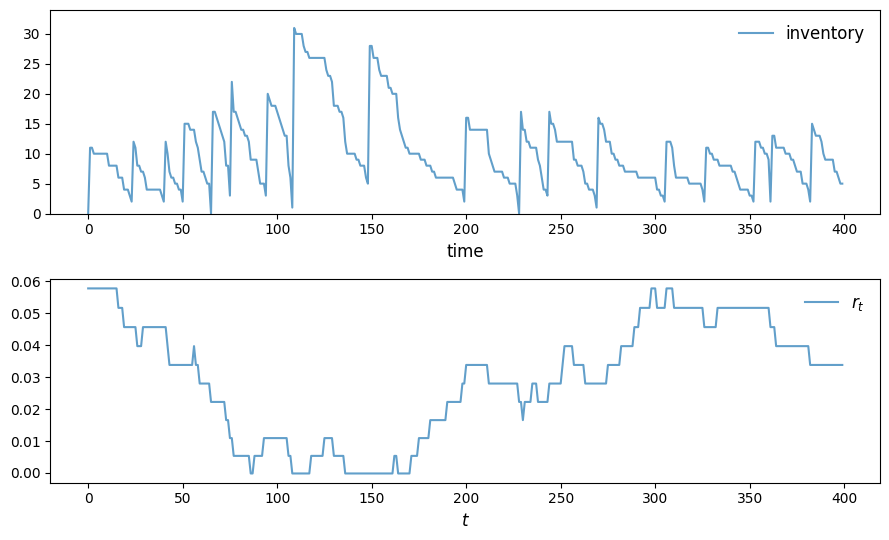

In [73]:
plot_ts(model, σ_star)

## Test timing

Solving model via using HPI.
HPI converged in 8 iteration(s).
TOC: Elapsed: 0:00:2.73
Solved model using HPI in 2.73933 seconds.
TOC: Elapsed: 0:00:2.73
Solving model via using VFI.
TOC: Elapsed: 0:02:18.45
Solved model using VFI in 138.45179 seconds.
TOC: Elapsed: 0:02:18.45
Solving model via using OPI.
OPI terminated successfully in 605 iterations (m = 1).
TOC: Elapsed: 0:02:16.40
Solved model using OPI in 136.40287 seconds.
TOC: Elapsed: 0:02:16.40
Solving model via using OPI.
OPI terminated successfully in 38 iterations (m = 21).
TOC: Elapsed: 0:00:9.31
Solved model using OPI in 9.31077 seconds.
TOC: Elapsed: 0:00:9.31
Solving model via using OPI.
OPI terminated successfully in 22 iterations (m = 41).
TOC: Elapsed: 0:00:5.82
Solved model using OPI in 5.82138 seconds.
TOC: Elapsed: 0:00:5.82
Solving model via using OPI.
OPI terminated successfully in 19 iterations (m = 61).
TOC: Elapsed: 0:00:5.40
Solved model using OPI in 5.40821 seconds.
TOC: Elapsed: 0:00:5.40
Solving model via u

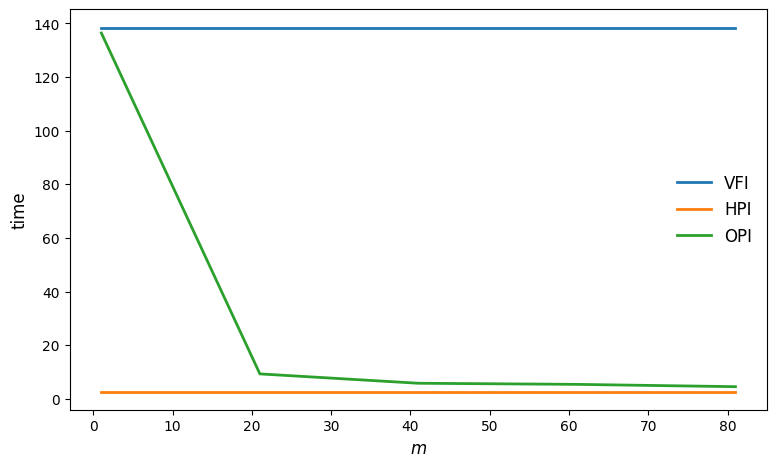

In [74]:
hpi_time, vfi_time, opi_times = test_timing_jax(model)

In [75]:
print("\nRun times relative to HPI:\n")
print(f"HPI = {hpi_time}")
print(f"VFI / HPI = {vfi_time / hpi_time}")
print(f"best OPI / HPI = {min(opi_times) / hpi_time}")


Run times relative to HPI:

HPI = 2.7393648624420166
VFI / HPI = 50.54161999817402
best OPI / HPI = 1.6590601048989058
